# Training and evaluation notebook
Round 4, no. 7 binary classification based on class 1 (drained) and 4 (restored) from the original dataset and trained on bands and VIs

In [11]:
## imports
import glob
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score

## 1. Construct dataset

In [12]:
merged_df = pd.read_csv('merged_df.csv')
merged_df


,Unnamed: 0,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,sample_location_id,classes,NDVI,EVI,NDWI,SAVI,GNDVI
0,0,0.00495,0.01885,0.03610,0.05020,0.09065,0.13930,0.15855,0.18270,0.19205,0.19175,0.20290,0.1097,201701,2,0.568914,0.246737,-0.052386,0.271183,0.670018
1,1,0.01040,0.02405,0.03980,0.05720,0.10385,0.16755,0.19370,0.21600,0.23420,0.24700,0.22290,0.1204,201701,2,0.581259,0.287926,-0.015721,0.308070,0.688819
2,2,0.01510,0.02905,0.06635,0.04515,0.12920,0.38280,0.47410,0.49955,0.50775,0.50890,0.24765,0.1219,201701,2,0.834221,0.731688,0.337125,0.652436,0.765506
3,3,0.01345,0.02925,0.06315,0.04920,0.12335,0.28515,0.33710,0.39055,0.37655,0.42050,0.23555,0.1175,201701,2,0.776236,0.581962,0.247564,0.544852,0.721622
4,4,0.01575,0.02970,0.06900,0.04870,0.13360,0.39940,0.49485,0.52430,0.53900,0.48935,0.23950,0.1177,201701,2,0.830017,0.746039,0.372872,0.664865,0.767403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152805,1152806,0.03720,0.04660,0.06660,0.08560,0.13300,0.21200,0.24360,0.26880,0.28690,0.27960,0.28600,0.1640,202312,2,0.516930,0.319632,-0.031002,0.321629,0.602862
1152806,1152807,0.03840,0.04250,0.07690,0.08000,0.14000,0.25190,0.28530,0.34760,0.33920,0.32180,0.29830,0.1563,202312,2,0.625819,0.443384,0.076328,0.432730,0.637691
1152807,1152808,0.04280,0.04960,0.06970,0.08880,0.12820,0.18960,0.21990,0.25540,0.25480,0.25390,0.27920,0.1567,202312,2,0.484021,0.294097,-0.044519,0.296020,0.571209
1152808,1152809,0.03170,0.04110,0.06480,0.07660,0.13350,0.23340,0.27290,0.30900,0.30940,0.29640,0.30290,0.1617,202312,2,0.602697,0.397850,0.009969,0.393631,0.653291


## 2. Add indices

In [13]:
merged_df['NDVI'] = (merged_df['B8'] - merged_df['B4']) / (merged_df['B8'] + merged_df['B4'])

# EVI is an optimized vegetation index designed to enhance the vegetation signal with improved sensitivity in high biomass regions
# It's calculated using the Red (B4), Near-Infrared (B8 or B5), and Blue (B2) bands.
merged_df['EVI'] = 2.5 * (merged_df['B8'] - merged_df['B4']) / (merged_df['B8'] + 6 * merged_df['B4'] - 7.5 * merged_df['B2'] + 1)

# NDWI is used to monitor changes in water content of leaves
# It is typically calculated using the Near-Infrared (B8 or B5) and Short-Wave Infrared (B11 or B6) bands.
merged_df['NDWI'] = (merged_df['B8'] - merged_df['B11']) / (merged_df['B8'] + merged_df['B11'])

# SAVI is a modification of NDVI to correct for the influence of soil brightness
# The standard value of L in the SAVI formula is 0.5.
L = 0.5  # soil brightness correction factor
merged_df['SAVI'] = ((merged_df['B8'] - merged_df['B4']) / (merged_df['B8'] + merged_df['B4'] + L)) * (1 + L)

# GNDVI is used to estimate vegetation health
# It's calculated using the Near-Infrared (B8 or B5) and Green (B3) bands.
merged_df['GNDVI'] = (merged_df['B8'] - merged_df['B3']) / (merged_df['B8'] + merged_df['B3'])

merged_df

,Unnamed: 0,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,sample_location_id,classes,NDVI,EVI,NDWI,SAVI,GNDVI
0,0,0.00495,0.01885,0.03610,0.05020,0.09065,0.13930,0.15855,0.18270,0.19205,0.19175,0.20290,0.1097,201701,2,0.568914,0.246737,-0.052386,0.271183,0.670018
1,1,0.01040,0.02405,0.03980,0.05720,0.10385,0.16755,0.19370,0.21600,0.23420,0.24700,0.22290,0.1204,201701,2,0.581259,0.287926,-0.015721,0.308070,0.688819
2,2,0.01510,0.02905,0.06635,0.04515,0.12920,0.38280,0.47410,0.49955,0.50775,0.50890,0.24765,0.1219,201701,2,0.834221,0.731688,0.337125,0.652436,0.765506
3,3,0.01345,0.02925,0.06315,0.04920,0.12335,0.28515,0.33710,0.39055,0.37655,0.42050,0.23555,0.1175,201701,2,0.776236,0.581962,0.247564,0.544852,0.721622
4,4,0.01575,0.02970,0.06900,0.04870,0.13360,0.39940,0.49485,0.52430,0.53900,0.48935,0.23950,0.1177,201701,2,0.830017,0.746039,0.372872,0.664865,0.767403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152805,1152806,0.03720,0.04660,0.06660,0.08560,0.13300,0.21200,0.24360,0.26880,0.28690,0.27960,0.28600,0.1640,202312,2,0.516930,0.319632,-0.031002,0.321629,0.602862
1152806,1152807,0.03840,0.04250,0.07690,0.08000,0.14000,0.25190,0.28530,0.34760,0.33920,0.32180,0.29830,0.1563,202312,2,0.625819,0.443384,0.076328,0.432730,0.637691
1152807,1152808,0.04280,0.04960,0.06970,0.08880,0.12820,0.18960,0.21990,0.25540,0.25480,0.25390,0.27920,0.1567,202312,2,0.484021,0.294097,-0.044519,0.296020,0.571209
1152808,1152809,0.03170,0.04110,0.06480,0.07660,0.13350,0.23340,0.27290,0.30900,0.30940,0.29640,0.30290,0.1617,202312,2,0.602697,0.397850,0.009969,0.393631,0.653291


In [14]:
# renaming 'class' column to 'classes' to fix python error
merged_df = merged_df.rename(columns={'class': 'classes'})

In the following, I will make some new dataframes for binary classification:

In [15]:
# Step 3: Create a DataFrame with classes 1 and 4
class_1_4_df = merged_df[merged_df['classes'].isin([1, 4])]


Dropping columns:

In [16]:
# Select only the columns you want to keep
class_1_4_df = class_1_4_df.loc[:, ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A',
                              'B9', 'B11', 'B12', 'classes', 'NDVI', 'EVI', 'NDWI', 'SAVI', 'GNDVI']]
class_1_4_df

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,classes,NDVI,EVI,NDWI,SAVI,GNDVI
9842,0.01865,0.05105,0.07580,0.06180,0.12655,0.27940,0.32480,0.35875,0.37050,0.35395,0.20805,0.10675,1,0.706099,0.551265,0.265879,0.483868,0.651133
9843,0.02580,0.05455,0.07065,0.06045,0.12780,0.26640,0.30535,0.33880,0.34985,0.33795,0.22375,0.11440,1,0.697182,0.538447,0.204515,0.464304,0.654903
9844,0.01355,0.03450,0.06355,0.05075,0.11345,0.24090,0.27965,0.30590,0.32365,0.31530,0.18985,0.10140,1,0.715407,0.471923,0.234090,0.446769,0.655975
9845,0.02700,0.04475,0.07310,0.07660,0.14820,0.27565,0.32250,0.34800,0.36675,0.36475,0.26760,0.15715,1,0.639190,0.460945,0.130604,0.440299,0.652814
9846,0.02190,0.04735,0.06520,0.05325,0.11545,0.26510,0.30440,0.32650,0.34915,0.35330,0.21820,0.11260,1,0.719552,0.529195,0.198825,0.465899,0.667092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107630,0.03940,0.04150,0.06540,0.07980,0.12370,0.19380,0.22340,0.24700,0.26710,0.27200,0.27330,0.15590,1,0.511628,0.295500,-0.050548,0.303338,0.581306
1107631,0.03630,0.03760,0.05900,0.07600,0.12830,0.20520,0.23680,0.25780,0.28190,0.29500,0.27540,0.15850,1,0.544638,0.317433,-0.033008,0.327057,0.627525
1107632,0.02560,0.03560,0.05040,0.06380,0.10790,0.18100,0.20570,0.22860,0.24280,0.26940,0.27770,0.15700,1,0.563611,0.306456,-0.096978,0.311964,0.638710
1107633,0.03450,0.04550,0.07100,0.08820,0.13700,0.23200,0.26630,0.28900,0.30960,0.31320,0.25640,0.15010,1,0.532344,0.339890,0.059773,0.343365,0.605556


## Constructing train and test sets

First shuffling dataset:



In [17]:
# Shuffle the DataFrame using a random seed, for example, seed=42
class_1_4_df = class_1_4_df.sample(frac=1, random_state=42).reset_index(drop=True)
class_1_4_df

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,classes,NDVI,EVI,NDWI,SAVI,GNDVI
0,0.03425,0.03845,0.0549,0.06870,0.13100,0.20070,0.23280,0.25870,0.27735,0.26380,0.24960,0.13535,4,0.580330,0.343574,0.017903,0.344453,0.649872
1,0.03250,0.04340,0.0643,0.06380,0.14050,0.26550,0.30340,0.31760,0.35510,0.31620,0.24390,0.12960,1,0.665443,0.461488,0.131256,0.431926,0.663263
2,0.03775,0.05730,0.0808,0.09515,0.14805,0.22945,0.25975,0.30075,0.29675,0.28945,0.25910,0.14280,1,0.519323,0.356474,0.074395,0.344235,0.576464
3,0.03440,0.04540,0.0744,0.06720,0.15140,0.30720,0.36230,0.39480,0.41350,0.42180,0.23620,0.12740,1,0.709091,0.561921,0.251347,0.510811,0.682864
4,0.03710,0.04320,0.0703,0.07140,0.13600,0.27470,0.32090,0.35600,0.36920,0.42830,0.23130,0.12350,1,0.665887,0.487195,0.212328,0.460319,0.670185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
744359,0.03420,0.04950,0.0728,0.06050,0.14080,0.29350,0.34160,0.37720,0.39280,0.36720,0.25400,0.12470,1,0.723555,0.578363,0.195184,0.506612,0.676444
744360,0.03510,0.04450,0.0628,0.06800,0.11520,0.18780,0.21130,0.24460,0.25600,0.27930,0.21960,0.11240,1,0.564939,0.334761,0.053856,0.325991,0.591412
744361,0.02590,0.03070,0.0487,0.04920,0.10770,0.20140,0.23210,0.25840,0.27360,0.30400,0.21370,0.10680,1,0.680104,0.395209,0.094683,0.388559,0.682839
744362,0.03420,0.04840,0.0686,0.08080,0.13400,0.19350,0.22380,0.24400,0.26620,0.26820,0.27060,0.15340,1,0.502463,0.298726,-0.051691,0.296799,0.561100


Then making splits:

In [18]:
from sklearn.model_selection import train_test_split

# Assuming your features are all columns except 'classes', and 'classes' is the target variable
X = class_1_4_df.drop('classes', axis=1)  # Features
y = class_1_4_df['classes']  # Target variable

# Perform the split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# X_train and y_train will now contain 70% of the data, X_test and y_test will contain 30%
# Both splits will have the same proportion of class 0 and 4 as the original dataset

## Hyperparameter optimisation

In [9]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def objective(trial):
    # Hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 400)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    # Ensuring min_samples_split is an int >= 2
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    # Ensuring min_samples_leaf is a float within (0.0, 0.5], you could also use suggest_int if you want specific integer values
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

    # Initialize the classifier with the current hyperparameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Train the classifier
    clf.fit(X_train, y_train)

    # Predict on the validation set
    predictions = clf.predict(X_test)

    # Compute and return the accuracy
    accuracy = accuracy_score(y_test, predictions)
    return accuracy

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # Adjust the number of trials as needed

print(f"Best trial: {study.best_trial.params}")

[I 2024-02-12 17:39:46,546] A new study created in memory with name: no-name-55e44e6e-0f70-434c-a6db-5942327c8598
[I 2024-02-12 17:42:59,345] Trial 0 finished with value: 0.7529174689892973 and parameters: {'n_estimators': 150, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.7529174689892973.
[I 2024-02-12 17:46:15,663] Trial 1 finished with value: 0.7161569119161704 and parameters: {'n_estimators': 259, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7529174689892973.
[I 2024-02-12 17:55:48,936] Trial 2 finished with value: 0.829738927947696 and parameters: {'n_estimators': 306, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.829738927947696.
[I 2024-02-12 18:04:07,574] Trial 3 finished with value: 0.8692266356186468 and parameters: {'n_estimators': 210, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.

Best trial: {'n_estimators': 398, 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 2}


## Training and evaluating

First using a logistic regression model:

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, accuracy_score
from sklearn.preprocessing import StandardScaler

# Initialize the Logistic Regression classifier
log_reg = LogisticRegression(max_iter=1000) # Increase max_iter if convergence warnings occur

# Train the classifier on the training set
log_reg.fit(X_train, y_train)

# Predict on the test set
log_reg_predictions = log_reg.predict(X_test)

# Predict on the test set
lr_predictions = log_reg.predict(X_test)

# Calculate metrics, specifying pos_label for binary classification
lr_precision = precision_score(y_test, lr_predictions, average='weighted')
log_reg_accuracy = accuracy_score(y_test, log_reg_predictions)
lr_recall = recall_score(y_test, lr_predictions, average='weighted')
lr_f1 = f1_score(y_test, lr_predictions, average='weighted')
lr_kappa = cohen_kappa_score(y_test, lr_predictions)

# Print metrics
print("Logistic Regression Performance:")
print(f"Precision: {lr_precision}")
print(f'Logistic Regression Accuracy: {log_reg_accuracy}')
print(f"Recall: {lr_recall}")
print(f"F1 Score: {lr_f1}")
print(f"Cohen's Kappa: {lr_kappa}")

Logistic Regression Performance:
Precision: 0.6892590098857939
Logistic Regression Accuracy: 0.7051856164076844
Recall: 0.7051856164076844
F1 Score: 0.668430491744793
Cohen's Kappa: 0.23646225680367183


Then an RF model based on optimised hyperparameters:

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, accuracy_score

# Best trial: {'n_estimators': 398, 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 2}

# Assuming you have your optimized hyperparameters, for example:
optimized_hyperparameters = {
    'n_estimators': 398,
    'max_depth': 31,
    'min_samples_split': 2,
    'min_samples_leaf': 2, 
    # Include other hyperparameters as necessary
}

# Initialize the RandomForestClassifier with optimized hyperparameters
clf = RandomForestClassifier(
    n_estimators=optimized_hyperparameters['n_estimators'],
    max_depth=optimized_hyperparameters['max_depth'],
    min_samples_split=optimized_hyperparameters['min_samples_split'],
    min_samples_leaf=optimized_hyperparameters['min_samples_leaf'],
    random_state=42  # Ensuring reproducibility
)

# Train the classifier on the training set
clf.fit(X_train, y_train)

# Predict on the test set
predictions = clf.predict(X_test)

# Compute and display the accuracy
accuracy = accuracy_score(y_test, predictions)
rf_precision = precision_score(y_test, predictions, average='weighted')
rf_recall = recall_score(y_test, predictions, average='weighted')
rf_f1 = f1_score(y_test, predictions, average='weighted')
rf_kappa = cohen_kappa_score(y_test, predictions)

# Print metrics
print("RandomForest Performance:")
print(f"Precision: {rf_precision}")
print(f"Recall: {rf_recall}")
print(f"F1 Score: {rf_f1}")
print(f"Cohen's Kappa: {rf_kappa}")
print(f'Optimized RandomForest Accuracy: {accuracy}')

RandomForest Performance:
Precision: 0.9427567110253074
Recall: 0.9421655993909811
F1 Score: 0.9414287923103802
Cohen's Kappa: 0.8672107740250168
Optimized RandomForest Accuracy: 0.9421655993909811


## Confusion matrix

- You'll also want to output an aggregated prediction confusion matrix (from the cross-validation), preferably as a seaborn (sns) figure. 

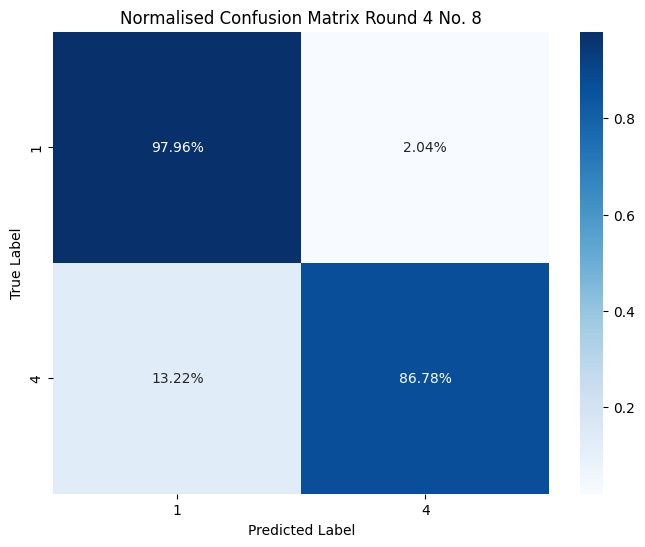

In [24]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming predictions, y_test are already defined

# Compute the normalized confusion matrix
cm_normalized = confusion_matrix(y_test, predictions, labels=[1, 4], normalize='true')

# Visualize the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap="Blues", xticklabels=[1, 4], yticklabels=[1, 4])
plt.title('Normalised Confusion Matrix Round 4 No. 8')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Feature permutation importance

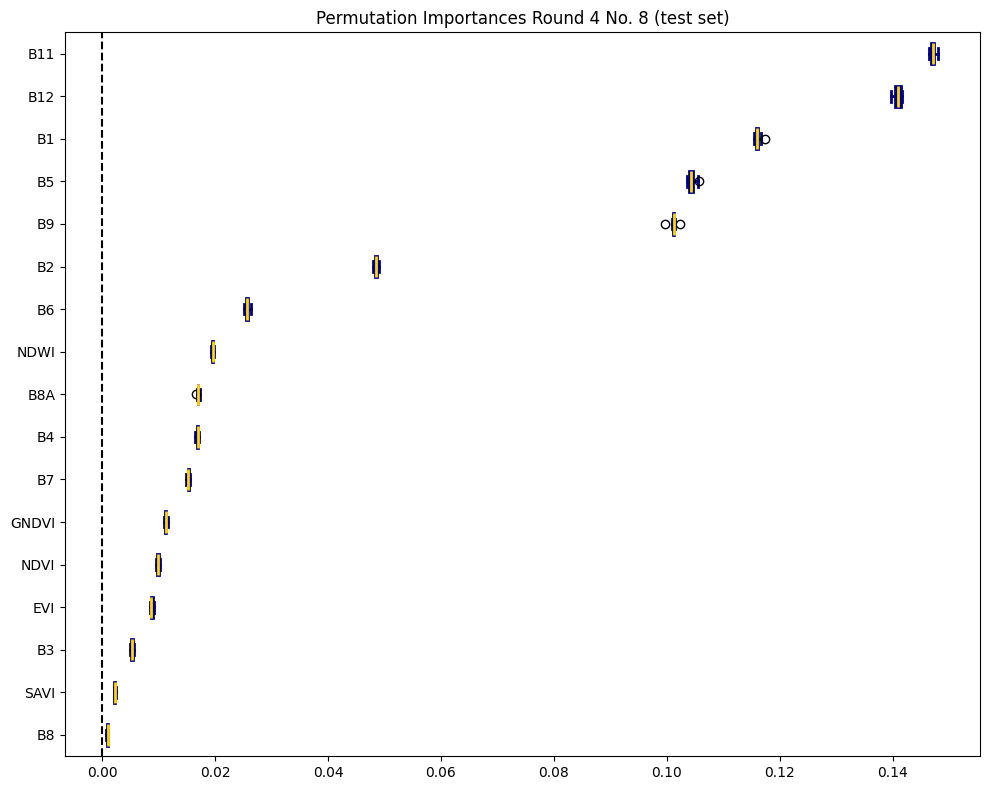

In [23]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# Assuming clf is your trained RandomForestClassifier model
# and X_test, y_test are your test datasets

result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=1)

# Sorting features by importance
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10, 8))
bp = ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx],
                patch_artist=True,  # To fill with color
                )

# Customizing the boxplot color to dark green
for box in bp['boxes']:
    # Change box color
    box.set(color='darkblue', linewidth=2)  # Box edge color
    box.set(facecolor='darkblue')  # Box fill color

# Optionally, customize whiskers, fliers, caps, and medians if needed
for whisker in bp['whiskers']:
    whisker.set(color='darkblue', linewidth=2)
for cap in bp['caps']:
    cap.set(color='darkblue', linewidth=2)
for median in bp['medians']:
    median.set(color='gold', linewidth=2)  # Making the median stand out

ax.axvline(x=0, color="k", linestyle="--")
ax.set_title("Permutation Importances Round 4 No. 8 (test set)")
plt.tight_layout()
plt.show()